In [1]:
!pip install tensorflow keras pillow

In [6]:


import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from PIL import Image
import zipfile
# Enable GPU acceleration
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
# Unzip Dataset
dataset_path = "/content/Train.zip"
extract_to = "/content/"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)



In [7]:
# Unzip Dataset
dataset_path = "/content/Validation.zip"
extract_to = "/content/"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)



In [101]:
import os
from PIL import Image

def remove_corrupt_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            img_path = os.path.join(root, file)
            if not os.path.isfile(img_path):  # ✅ Skip directories
                continue
            try:
                with Image.open(img_path) as img:
                    img.verify()  # Check if image is valid
            except (IOError, SyntaxError):
                print(f"Removing corrupt image: {img_path}")
                os.remove(img_path)  # ✅ Delete corrupt images

# ✅ Run cleanup on both train and validation sets
train_dir = "/content/Train"
val_dir = "/content/Validation"

remove_corrupt_images(train_dir)
remove_corrupt_images(val_dir)

In [106]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Only Rescale for Validation
val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/content/Train/', target_size=(224, 224),
    batch_size=32, class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Get Number of Classes
num_classes = len(train_generator.class_indices)
print(f"Detected {num_classes} classes.")

Found 15447 images belonging to 42 classes.
Found 3171 images belonging to 42 classes.
Detected 42 classes.


In [108]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dense(len(class_indices), activation='softmax')(x)  # Corrected

# Create model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,427,370 (9.26 MB)

 Trainable params: 169,386 (661.66 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [110]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Get class labels from the training generator
labels = train_generator.classes  # Extract class labels

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance class distribution
    classes=np.unique(labels),  # Unique class labels
    y=labels  # The actual labels
)

# Convert to dictionary
class_weight_dict = dict(enumerate(class_weights))

# Print computed class weights
print("Class Weights:", class_weight_dict)

# ✅ Now use class_weight in model training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Adjust as needed
    class_weight=class_weight_dict  # ✅ Now properly defined
)

Class Weights: {0: np.float64(6.567602040816326), 1: np.float64(12.682266009852217), 2: np.float64(9.194642857142858), 3: np.float64(0.23218795093795094), 4: np.float64(0.2242595818815331), 5: np.float64(0.28161233865674906), 6: np.float64(9.43040293040293), 7: np.float64(2.0546687948922586), 8: np.float64(0.640741662518666), 9: np.float64(0.316510941726088), 10: np.float64(1.2638684339715267), 11: np.float64(0.8653781512605042), 12: np.float64(0.8819801301815691), 13: np.float64(9.194642857142858), 14: np.float64(0.7960729746444032), 15: np.float64(0.6212596525096525), 16: np.float64(4.903809523809524), 17: np.float64(0.255406746031746), 18: np.float64(0.7045703338806787), 19: np.float64(0.2811817387505461), 20: np.float64(4.086507936507936), 21: np.float64(2.1382890365448506), 22: np.float64(2.3576007326007327), 23: np.float64(2.2843833185448092), 24: np.float64(2.5719280719280717), 25: np.float64(2.3882189239332097), 26: np.float64(2.176246830092984), 27: np.float64(3.87142857142857

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


483/483 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7708 - loss: 0.9288

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


483/483 ━━━━━━━━━━━━━━━━━━━━ 258s 534ms/step - accuracy: 0.7708 - loss: 0.9288 - val_accuracy: 0.1892 - val_loss: 6.1903
Epoch 2/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 262s 541ms/step - accuracy: 0.7850 - loss: 0.8767 - val_accuracy: 0.1958 - val_loss: 6.3873
Epoch 3/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 265s 550ms/step - accuracy: 0.8013 - loss: 0.8082 - val_accuracy: 0.1999 - val_loss: 6.5839
Epoch 4/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 262s 543ms/step - accuracy: 0.8188 - loss: 0.7074 - val_accuracy: 0.2053 - val_loss: 6.7599
Epoch 5/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 262s 541ms/step - accuracy: 0.8294 - loss: 0.6774 - val_accuracy: 0.2119 - val_loss: 7.0346
Epoch 6/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 265s 550ms/step - accuracy: 0.8360 - loss: 0.6432 - val_accuracy: 0.2044 - val_loss: 7.3009
Epoch 7/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 266s 550ms/step - accuracy: 0.8363 - loss: 0.6083 - val_accuracy: 0.1974 - val_loss: 7.3446
Epoch 8/10
483/483 ━━━━━━━━━━━━━━━━━━━━ 260s 538ms/step - accuracy: 0.8514 - loss: 0.56

In [111]:
from google.colab import files
import pickle

# Save Model
model.save("crop_disease_model.h5")
print("Model saved as crop_disease_model.h5")

# Download Model File
files.download("crop_disease_model.h5")

# Save Class Indices
class_indices = train_generator.class_indices
with open("class_indices.pkl", "wb") as f:
    pickle.dump(class_indices, f)

print("Class indices saved as class_indices.pkl")

# Download Class Indices File
files.download("class_indices.pkl")

Model saved as crop_disease_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Class indices saved as class_indices.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [113]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_indices):
    # Load Image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions)

    # Convert index to class name
    class_labels = {v: k for k, v in class_indices.items()}
    return class_labels[class_idx]

# Example Usage
img_path = "/content/Validation/Army worm/1.jpg"  # Change to an actual image path
predicted_class = predict_image(img_path, model, class_indices)
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Class: Army worm


In [114]:
import numpy as np
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained model
model = load_model("/content/crop_disease_model.h5")  # Ensure the correct path

# Load class indices
with open("/content/class_indices.pkl", "rb") as f:
    class_indices = pickle.load(f)

# Define function for prediction
def predict_image(img_path, model, class_indices):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions)

    # Convert index to class name
    class_labels = {v: k for k, v in class_indices.items()}

    # Handle unknown predictions (optional safety check)
    predicted_class = class_labels.get(class_idx, "Unknown Class")
    return predicted_class

# Example Usage
img_path = "/content/Validation/Healthy Maize/Corn_Health (435).JPG"  # Ensure this path exists
predicted_class = predict_image(img_path, model, class_indices)
print(f"Predicted Class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Healthy Maize


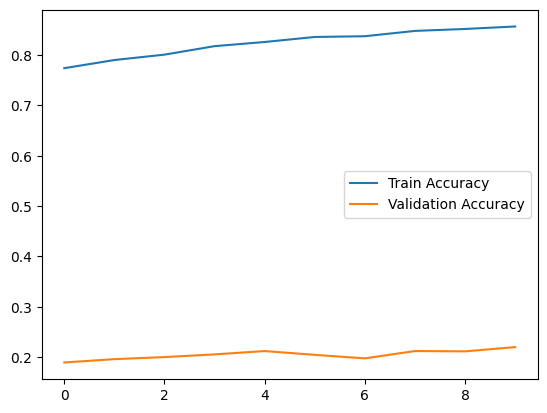

In [115]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()